In [216]:
import numpy as np
np.set_printoptions(suppress=True, precision=4)
import pandas as pd
from matplotlib import pyplot as plt
#%matplotlib widget
import seaborn as sns
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import metrics
from sklearn import preprocessing

import tensorflow as tf
from keras.models import Sequential
from keras.layers import *
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import  GRU, Dense, TimeDistributed

# Data

In [217]:
palm_file = './data_2024/2024-12-02_14-03-05.emg8'
gestures = pd.read_csv(palm_file, sep= ' ', on_bad_lines='warn')
gestures = gestures.query('id != -1')

display(gestures.head())

GESTURES = gestures['state'].unique()
# renumerate gestures from zero
gestures['id'] = gestures['state'].replace({gesture: i for i, gesture in enumerate(GESTURES)})

display(gestures[['id', 'state']].drop_duplicates())

,ts,td,omg0,omg1,omg2,omg3,omg4,omg5,omg6,omg7,...,prb4,prb5,prb6,prb7,argmax,denoize,prot,state,id,now
125,259894.0,40.0,7363637.0,7679207.0,6738769.0,6807792.0,7093060.0,7345307.0,4508646.0,5455380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.00
126,259934.0,40.0,7363709.0,7677939.0,6739193.0,6809703.0,7090766.0,7350908.0,4508409.0,5454744.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.04
127,259974.0,40.0,7363421.0,7678858.0,6739722.0,6810181.0,7093216.0,7344666.0,4507811.0,5452818.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.08
128,260014.0,40.0,7367262.0,7678726.0,6740724.0,6811853.0,7094905.0,7352312.0,4508478.0,5452612.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.12
129,260054.0,40.0,7367503.0,7684171.0,6742614.0,6810956.0,7094223.0,7351360.0,4507379.0,5452287.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.16


,id,state
125,0,Neutral
225,1,ThumbFingers
375,2,Close
525,3,Open
675,4,Pinch
825,5,Indication
975,6,Wrist_Flex
1125,7,Wrist_Extend


In [218]:
gestures.head()

,ts,td,omg0,omg1,omg2,omg3,omg4,omg5,omg6,omg7,...,prb4,prb5,prb6,prb7,argmax,denoize,prot,state,id,now
125,259894.0,40.0,7363637.0,7679207.0,6738769.0,6807792.0,7093060.0,7345307.0,4508646.0,5455380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.00
126,259934.0,40.0,7363709.0,7677939.0,6739193.0,6809703.0,7090766.0,7350908.0,4508409.0,5454744.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.04
127,259974.0,40.0,7363421.0,7678858.0,6739722.0,6810181.0,7093216.0,7344666.0,4507811.0,5452818.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.08
128,260014.0,40.0,7367262.0,7678726.0,6740724.0,6811853.0,7094905.0,7352312.0,4508478.0,5452612.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.12
129,260054.0,40.0,7367503.0,7684171.0,6742614.0,6810956.0,7094223.0,7351360.0,4507379.0,5452287.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,Neutral,0,5.16


In [219]:
gestures.columns

Index(['ts', 'td', 'omg0', 'omg1', 'omg2', 'omg3', 'omg4', 'omg5', 'omg6',
       'omg7', 'omg8', 'omg9', 'omg10', 'omg11', 'omg12', 'omg13', 'omg14',
       'omg15', 'emg0', 'emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7',
       'bno0', 'bno1', 'bno2', 'prb0', 'prb1', 'prb2', 'prb3', 'prb4', 'prb5',
       'prb6', 'prb7', 'argmax', 'denoize', 'prot', 'state', 'id', 'now'],
      dtype='object')

In [220]:
drop_features = ['ts','td','emg0', 'emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6', 'emg7',
       'bno0', 'bno1', 'bno2', 'prb0', 'prb1', 'prb2', 'prb3', 'prb4', 'prb5',
       'prb6', 'prb7', 'argmax', 'denoize', 'now','prot','state']
gestures = gestures.drop(drop_features, axis=1)

In [221]:
gestures.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5500 entries, 125 to 5624
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   omg0    5500 non-null   float64
 1   omg1    5500 non-null   float64
 2   omg2    5500 non-null   float64
 3   omg3    5500 non-null   float64
 4   omg4    5500 non-null   float64
 5   omg5    5500 non-null   float64
 6   omg6    5500 non-null   float64
 7   omg7    5500 non-null   float64
 8   omg8    5500 non-null   float64
 9   omg9    5500 non-null   float64
 10  omg10   5500 non-null   float64
 11  omg11   5500 non-null   float64
 12  omg12   5500 non-null   float64
 13  omg13   5500 non-null   float64
 14  omg14   5500 non-null   float64
 15  omg15   5500 non-null   float64
 16  id      5500 non-null   int64  
dtypes: float64(16), int64(1)
memory usage: 773.4 KB


In [222]:
N_OMG_CH = 16

OMG_CH = [f'omg{i}' for i in range(N_OMG_CH)]

print(f"OMG_CH: {list(OMG_CH)}")

OMG_CH: ['omg0', 'omg1', 'omg2', 'omg3', 'omg4', 'omg5', 'omg6', 'omg7', 'omg8', 'omg9', 'omg10', 'omg11', 'omg12', 'omg13', 'omg14', 'omg15']


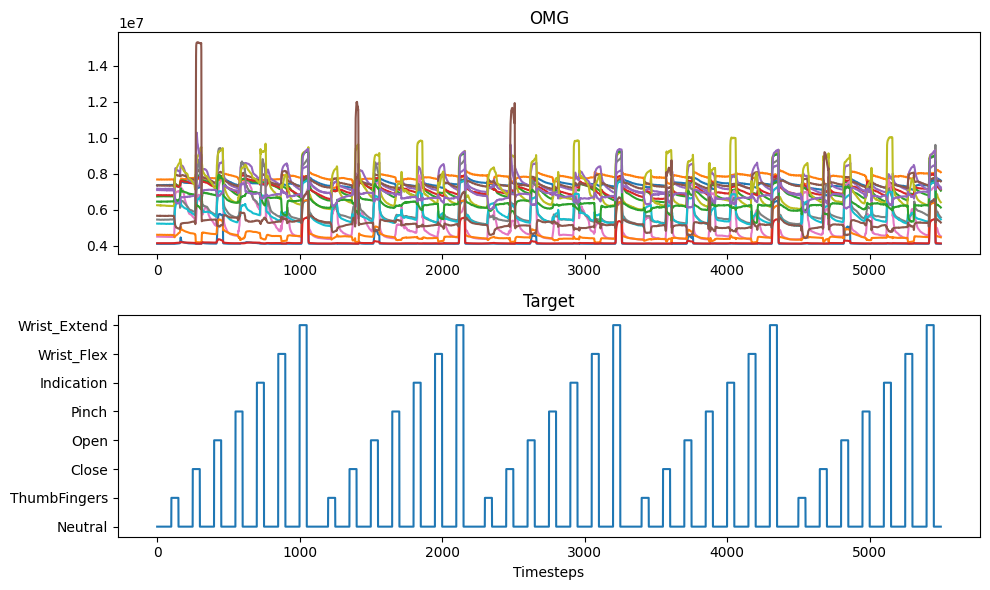

In [223]:
fig, axx = plt.subplots(2, 1, figsize=(10, 6))
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')

plt.sca(axx[1])
plt.plot(gestures['id'].values)
plt.title('Target')
plt.yticks(np.arange(len(GESTURES)), GESTURES)

plt.xlabel('Timesteps')
plt.tight_layout()

In [224]:
def plot_sensors(df, cols, range_: range):
    '''
    Отображаем в указанном диапазоне показания ожидаемых сенсоров
    '''

    fig, axes = plt.subplots(10, 5, figsize=(20, 20), sharex=True, sharey=True)

    # Преобразуем 2D массив осей в 1D массив для удобства
    axes = axes.flatten()

    for i, column in enumerate(cols):
        axes[i].plot(df[column].values[range_])
        axes[i].set_title(column)

    # Удаляем лишние подграфики, если их меньше 50
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    #experiment.log_figure(figure=plt)
    plt.show()
    

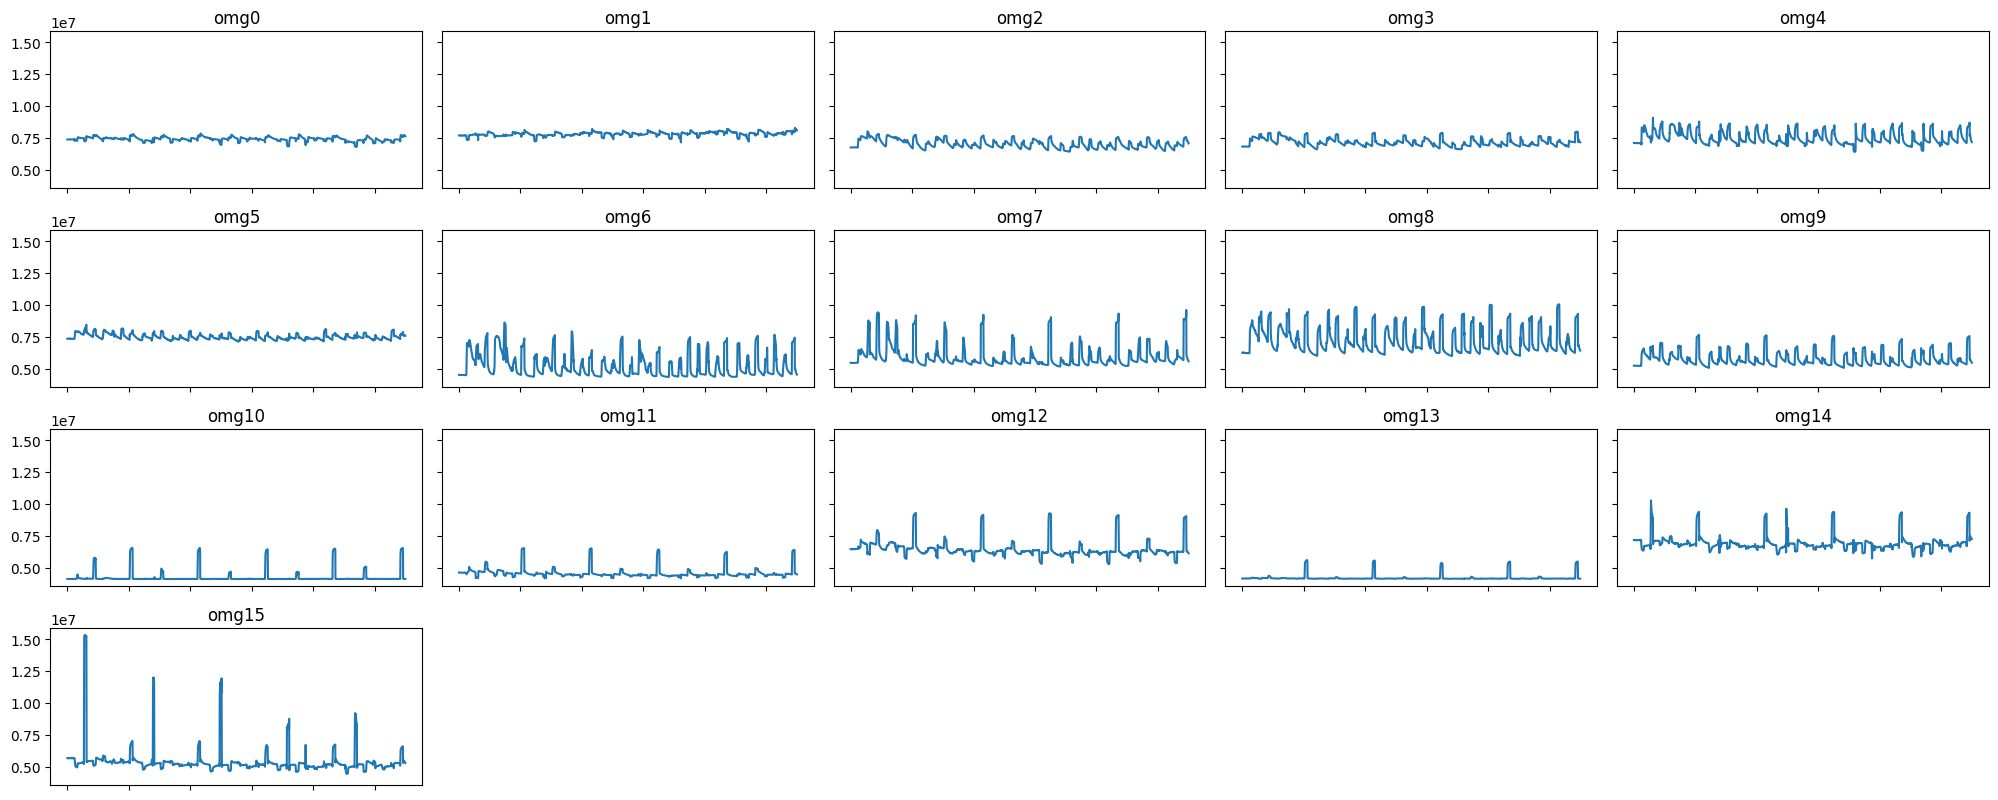

In [225]:
plot_sensors(gestures, OMG_CH, range(gestures.shape[0]))

In [ ]:
#Для начала считываем необходимые данные
#target_data = pd.read_csv('data_2024/2024-12-04_12-22-13.emg8.protocol', index_col=0)
#print(f'Target data shape: {target_data.shape}')
#target_data = target_data.query('ID != -1')
#Посмотрим правильно ли они считались
#target_data.head(10)

Target data shape: (117, 19)


,State,ID,Duration,Abs,thumb_flex,index_flex,middle_flex,ring_flex,pinky_flex,thumb_extend,index_extend,middle_extend,ring_extend,pinky_extend,wrist_flex,wrist_extend,wrist_adduction,wrist_abduction,wrist_pronation
1,Neutral,0,2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5
2,Neutral,0,2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5
3,ThumbFingers,6,2,11,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0.5
4,Neutral,0,2,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5
5,Neutral,0,2,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5
6,Close,1,2,17,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0.5
7,Neutral,0,2,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5
8,Neutral,0,2,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5
9,Open,2,2,23,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0.5
10,Neutral,0,2,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5


In [ ]:
#target_data.columns

Index(['State', 'ID', 'Duration', 'Abs', 'thumb_flex', 'index_flex',
       'middle_flex', 'ring_flex', 'pinky_flex', 'thumb_extend',
       'index_extend', 'middle_extend', 'ring_extend', 'pinky_extend',
       'wrist_flex', 'wrist_extend', 'wrist_adduction', 'wrist_abduction',
       'wrist_pronation'],
      dtype='object')

In [ ]:
#target_data['State'] = target_data['State'].replace({gesture: i for i, gesture in enumerate(GESTURES)})

In [ ]:
#target_data.head()

,State,ID,Duration,Abs,thumb_flex,index_flex,middle_flex,ring_flex,pinky_flex,thumb_extend,index_extend,middle_extend,ring_extend,pinky_extend,wrist_flex,wrist_extend,wrist_adduction,wrist_abduction,wrist_pronation
1,0,0,2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5
2,0,0,2,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5
3,1,6,2,11,1,0,0,0,0,0,1,1,1,1,0,0,0,0,0.5
4,0,0,2,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5
5,0,0,2,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.5


In [ ]:
#Формируем целевой признак
#gestures['id'] = gestures['prot'].apply(lambda x: target_data['State'].loc[x])
#Удаляем ненужный столбец
#gestures = gestures.drop('prot', axis=1)
#gestures.head()

,omg0,omg1,omg2,omg3,omg4,omg5,omg6,omg7,omg8,omg9,omg10,omg11,omg12,omg13,omg14,omg15,state,id
125,8495455.0,11055816.0,8492304.0,7062228.0,6459652.0,9042609.0,8853486.0,9314003.0,12365016.0,9720643.0,10506043.0,10135130.0,13780160.0,12648492.0,12683913.0,11828263.0,Neutral,0
126,8485483.0,11057190.0,8499204.0,7059269.0,6455352.0,9046354.0,8847785.0,9307901.0,12365203.0,9727076.0,10507279.0,10134598.0,13772295.0,12644906.0,12688507.0,11846990.0,Neutral,0
127,8481604.0,11051665.0,8506033.0,7050316.0,6454839.0,9047042.0,8838879.0,9300121.0,12364010.0,9717485.0,10507668.0,10132950.0,13769002.0,12643561.0,12694037.0,11860480.0,Neutral,0
128,8497094.0,11060692.0,8503469.0,7043050.0,6460561.0,9045643.0,8837353.0,9293303.0,12363478.0,9719321.0,10507924.0,10129335.0,13770455.0,12647108.0,12696864.0,11859991.0,Neutral,0
129,8501346.0,11051522.0,8507699.0,7047528.0,6462165.0,9046531.0,8839184.0,9296172.0,12365183.0,9724100.0,10507211.0,10126149.0,13768244.0,12645720.0,12690164.0,11846914.0,Neutral,0


In [226]:
gestures.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5500 entries, 125 to 5624
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   omg0    5500 non-null   float64
 1   omg1    5500 non-null   float64
 2   omg2    5500 non-null   float64
 3   omg3    5500 non-null   float64
 4   omg4    5500 non-null   float64
 5   omg5    5500 non-null   float64
 6   omg6    5500 non-null   float64
 7   omg7    5500 non-null   float64
 8   omg8    5500 non-null   float64
 9   omg9    5500 non-null   float64
 10  omg10   5500 non-null   float64
 11  omg11   5500 non-null   float64
 12  omg12   5500 non-null   float64
 13  omg13   5500 non-null   float64
 14  omg14   5500 non-null   float64
 15  omg15   5500 non-null   float64
 16  id      5500 non-null   int64  
dtypes: float64(16), int64(1)
memory usage: 773.4 KB


In [144]:
#gestures = gestures.drop('state', axis=1)

In [227]:
gestures.shape

(5500, 17)

In [228]:
gestures.head()

,omg0,omg1,omg2,omg3,omg4,omg5,omg6,omg7,omg8,omg9,omg10,omg11,omg12,omg13,omg14,omg15,id
125,7363637.0,7679207.0,6738769.0,6807792.0,7093060.0,7345307.0,4508646.0,5455380.0,6251806.0,5232828.0,4110404.0,4612195.0,6453119.0,4144286.0,7162712.0,5664490.0,0
126,7363709.0,7677939.0,6739193.0,6809703.0,7090766.0,7350908.0,4508409.0,5454744.0,6249304.0,5231419.0,4110895.0,4611214.0,6454325.0,4143961.0,7160745.0,5664935.0,0
127,7363421.0,7678858.0,6739722.0,6810181.0,7093216.0,7344666.0,4507811.0,5452818.0,6248969.0,5231903.0,4111110.0,4609890.0,6456479.0,4144926.0,7159677.0,5662140.0,0
128,7367262.0,7678726.0,6740724.0,6811853.0,7094905.0,7352312.0,4508478.0,5452612.0,6251254.0,5234502.0,4109921.0,4612348.0,6453198.0,4142455.0,7155703.0,5658132.0,0
129,7367503.0,7684171.0,6742614.0,6810956.0,7094223.0,7351360.0,4507379.0,5452287.0,6245987.0,5231113.0,4110230.0,4610480.0,6456057.0,4144939.0,7163485.0,5663963.0,0


## Data analysis

Рассмотрим наши временные ряды более локально, будем просматривать каждые 100 временных шагов.

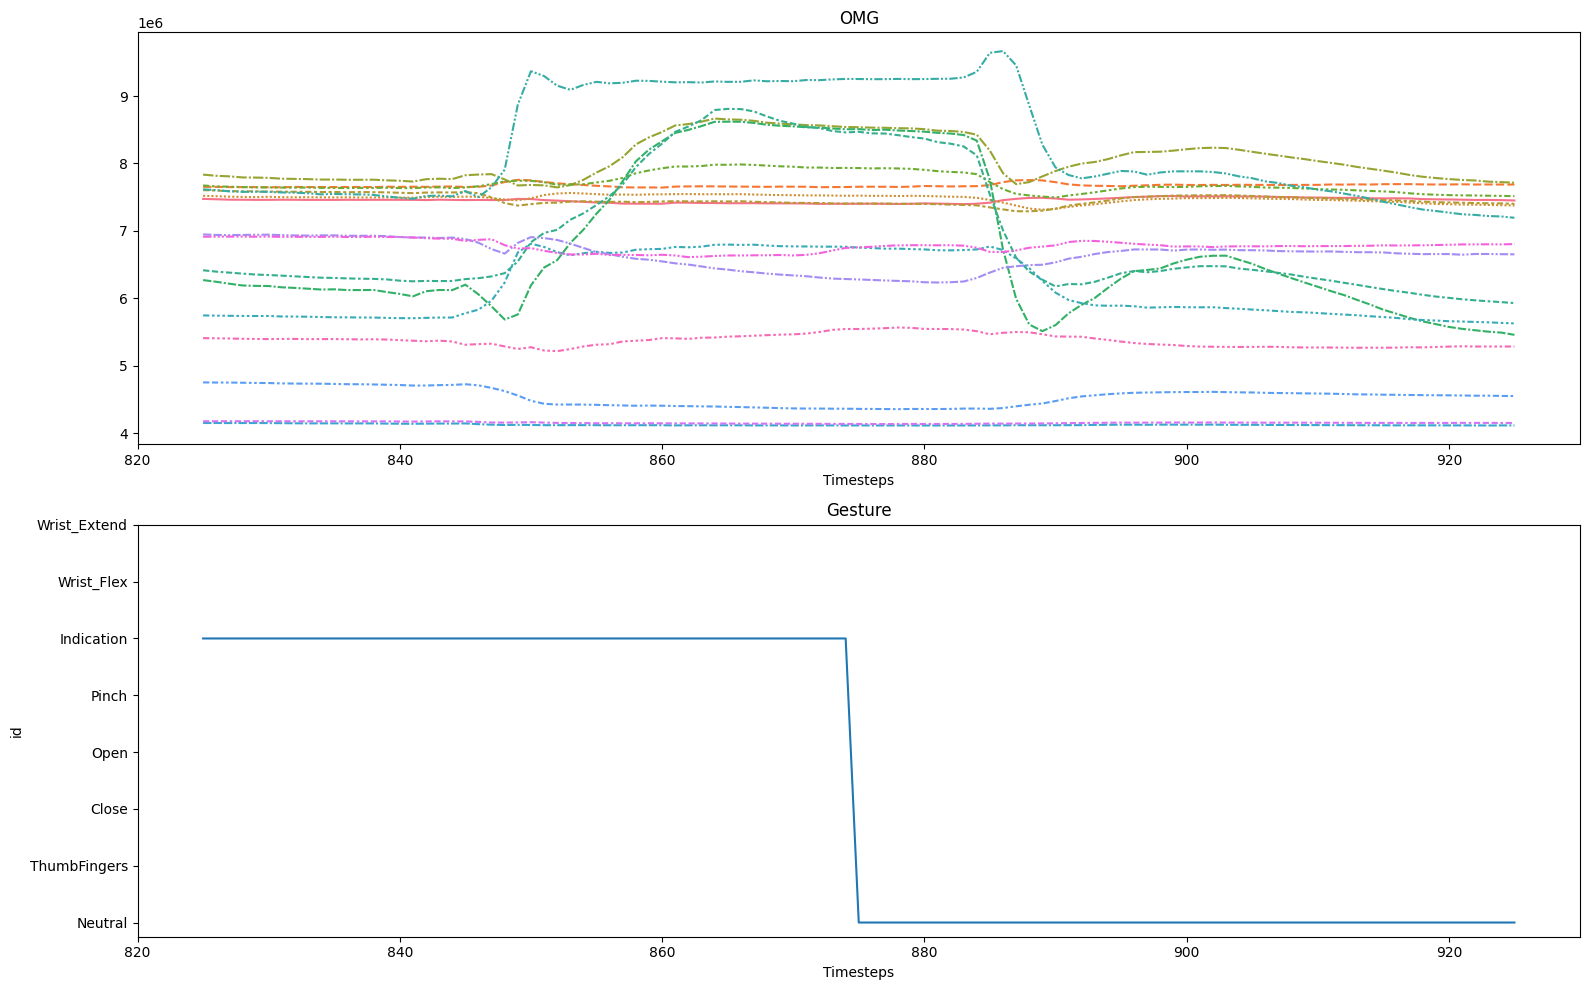

In [229]:
sample_number = 7

#Имена жестов
GESTURES

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(gestures.drop('id', axis=1).iloc[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(gestures['id'].iloc[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(GESTURES)), GESTURES)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

## Data Forming

n: 16, cor: 0.3355252856186515


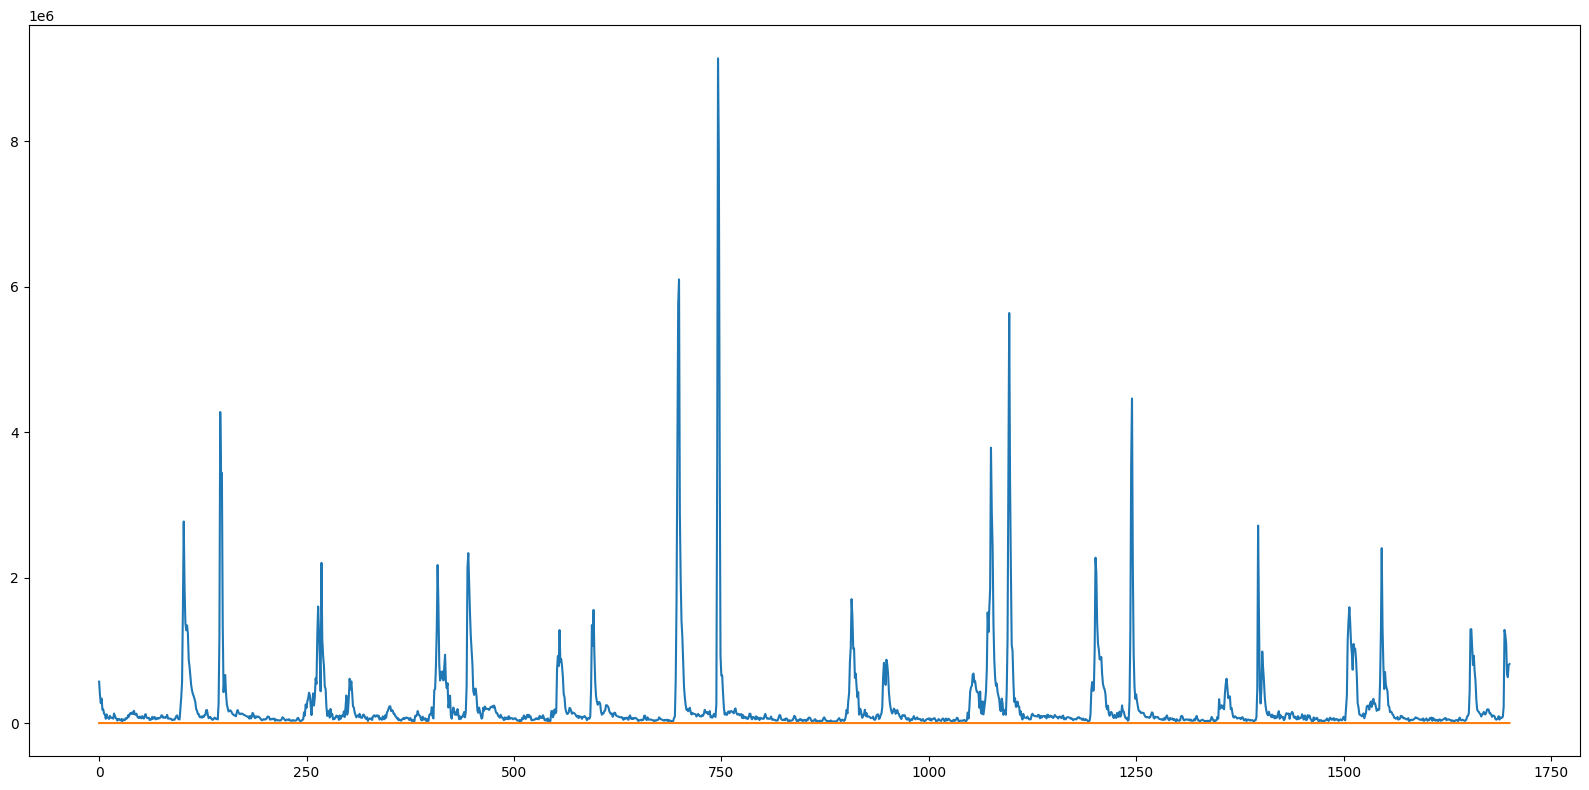

In [230]:
def data_shifter(data, n):
    """Смещает данные на n единиц

    Args:
        data: Данные
        n: Кол-во единиц

    Returns:
        X: Смещенные данные
    """
    X = data.drop('id', axis=1) #Матрица наблюдений
    y = data['id'] #Вектор правильных ответов
    #Смещаем данные
    X = X.iloc[n:].reset_index(drop=True)
    X['id'] = y.iloc[:-n].reset_index(drop=True)
    return X

def get_sum_derivative(data):
    """Возвращает сумму абсолютных значений производных

    Args:
        data: Наши данные

    Returns:
        result: Серия сумм абсолютных значений производных
    """
    result = abs(data.drop('id', axis=1).diff()).sum(axis=1)
    return result

def get_best_shifter(data, res_plot=False):
    #Формируем ряд выполнения жестов.
    gestures = data['id'].apply(lambda x: 500 if x > 0 else 0)
    #Ряд производных
    derivatives = get_sum_derivative(data)
    #Словарь с результатом
    result = {'n': 0, 'cor': 0}
    #Находим лучший шифтер
    for n in range(1, 41):
        cor = np.corrcoef(derivatives.iloc[n:].values, gestures.iloc[:-n].values)[0][1]
        if cor > result['cor']:
            result['n'] = n
            result['cor'] = cor
            
    if res_plot: #Если необходимо строим график с полученным сдвигом для первых 2000 таймстепов.
        fig, axes = plt.subplots(1, 1, figsize=(16, 8))
        sns.lineplot(derivatives.iloc[result['n']:].values[300:2001], ax=axes, legend=False)
        sns.lineplot(gestures.iloc[:-result['n']].values[300:2001], ax=axes, legend=False)
        plt.tight_layout()
    #Выводим результат    
    print(f'n: {result["n"]}, cor: {result["cor"]}')
    #Возвращаем словарь с найденным n и корреляцией
    return result
    
#Применяем полученную функцию
n = get_best_shifter(gestures, res_plot=True)['n']

In [231]:
#new cell
#Применяем функцию
gestures = data_shifter(gestures, n)
print(f'Data shape: {gestures.shape}')
gestures

Data shape: (5484, 17)


,omg0,omg1,omg2,omg3,omg4,omg5,omg6,omg7,omg8,omg9,omg10,omg11,omg12,omg13,omg14,omg15,id
0,7365293.0,7675009.0,6742353.0,6808370.0,7095452.0,7348981.0,4504357.0,5455176.0,6249429.0,5232633.0,4111016.0,4612142.0,6451949.0,4144737.0,7161216.0,5667468.0,0
1,7364723.0,7675728.0,6744021.0,6810516.0,7091509.0,7344326.0,4503962.0,5450863.0,6245452.0,5229499.0,4111212.0,4610057.0,6455162.0,4144323.0,7159820.0,5665951.0,0
2,7366773.0,7677622.0,6743726.0,6811006.0,7089276.0,7346298.0,4501621.0,5451786.0,6242983.0,5229791.0,4109627.0,4611196.0,6450207.0,4144302.0,7157906.0,5664161.0,0
3,7363720.0,7676388.0,6743597.0,6808710.0,7091128.0,7344922.0,4500847.0,5445076.0,6238155.0,5226395.0,4110840.0,4607830.0,6449958.0,4143966.0,7159766.0,5664410.0,0
4,7367495.0,7678619.0,6744013.0,6809814.0,7087942.0,7346547.0,4500076.0,5445488.0,6239732.0,5224279.0,4111459.0,4607285.0,6448662.0,4144374.0,7159335.0,5664356.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5479,7648702.0,8121080.0,7099916.0,7165145.0,7206625.0,7610462.0,4550382.0,5610916.0,6454111.0,5496056.0,4111641.0,4480561.0,6157521.0,4135079.0,7276190.0,5334981.0,0
5480,7642792.0,8120994.0,7091790.0,7160919.0,7200985.0,7605746.0,4545382.0,5603992.0,6447473.0,5490336.0,4111226.0,4476640.0,6152166.0,4134418.0,7264174.0,5326513.0,0
5481,7635590.0,8117095.0,7082574.0,7160811.0,7192675.0,7603618.0,4541028.0,5595879.0,6439133.0,5482882.0,4110658.0,4475012.0,6151444.0,4133231.0,7261763.0,5314586.0,0
5482,7633212.0,8102794.0,7071596.0,7151592.0,7178052.0,7592076.0,4535405.0,5584248.0,6427458.0,5476362.0,4111149.0,4472151.0,6132892.0,4133275.0,7241306.0,5302561.0,0


Посмотрим на данные после применения шифтера:

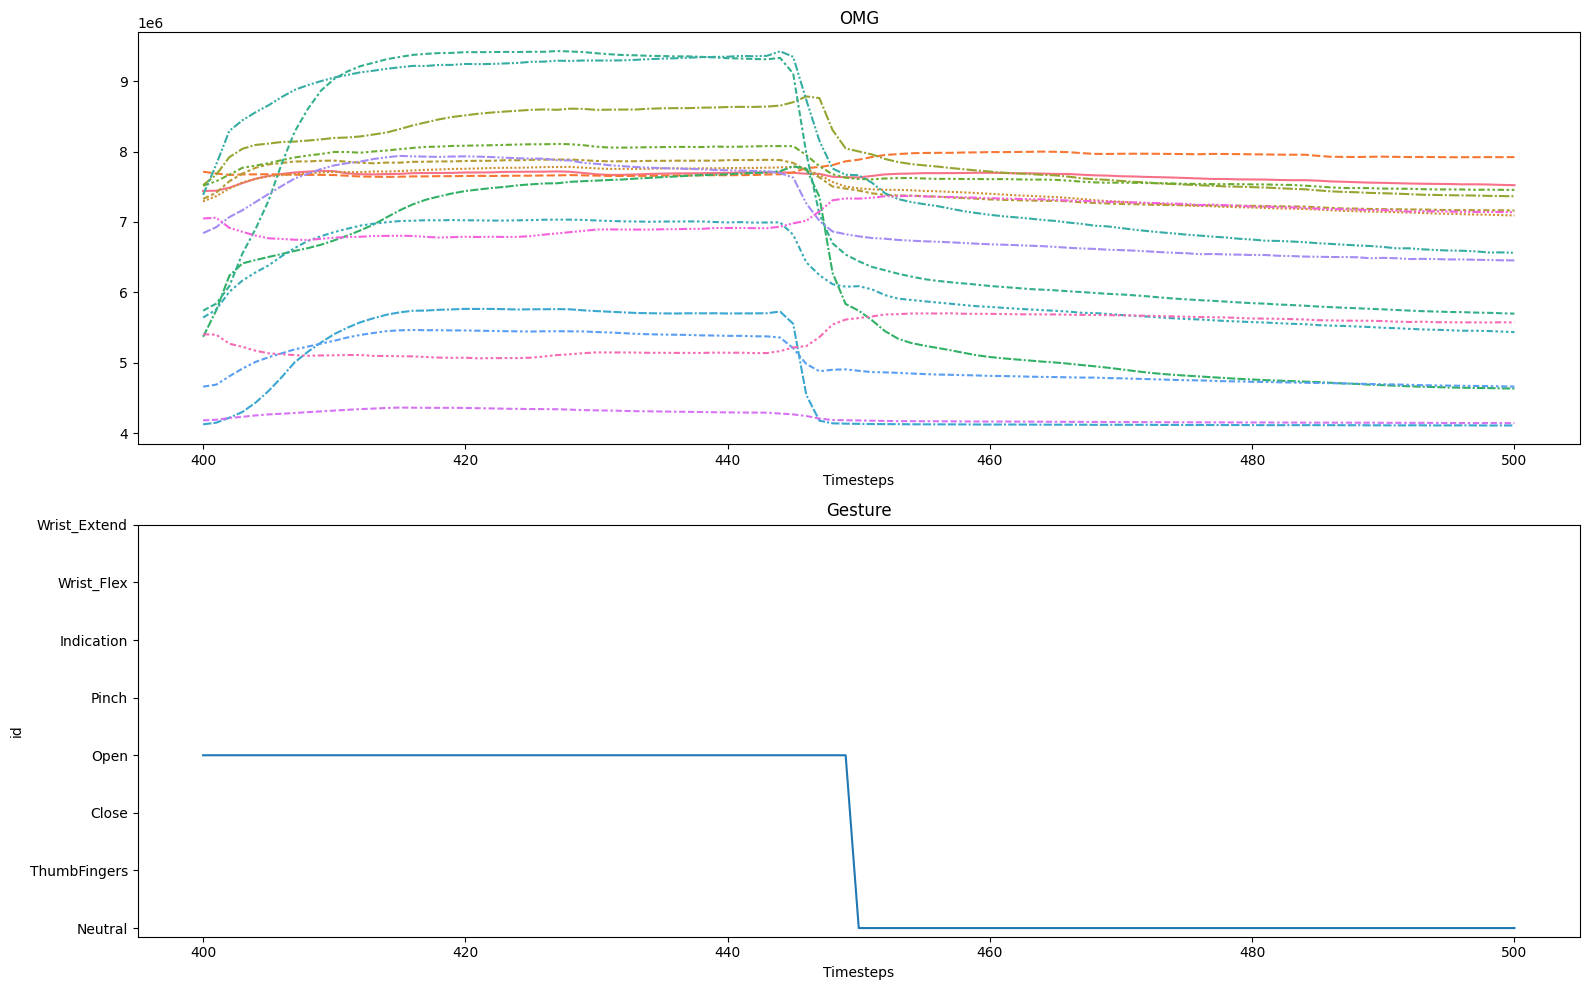

In [232]:
#new cell
sample_number = 4

#Имена жестов
GESTURES

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
#Графики датчиков
sns.lineplot(gestures.drop('id', axis=1).iloc[100 * sample_number: 100 * (sample_number + 1) + 1], ax=axes[0], legend=False)
axes[0].set_title('OMG')
axes[0].set_xlabel('Timesteps')
#График таргета
sns.lineplot(gestures['id'].iloc[100 * sample_number:100 * (sample_number + 1) + 1], ax=axes[1], legend=False)
axes[1].set_title('Gesture')
axes[1].set_yticks(np.arange(len(GESTURES)), GESTURES)
axes[1].set_xlabel('Timesteps')
plt.tight_layout()

Text(0.5, 1.0, 'Баланс классов')

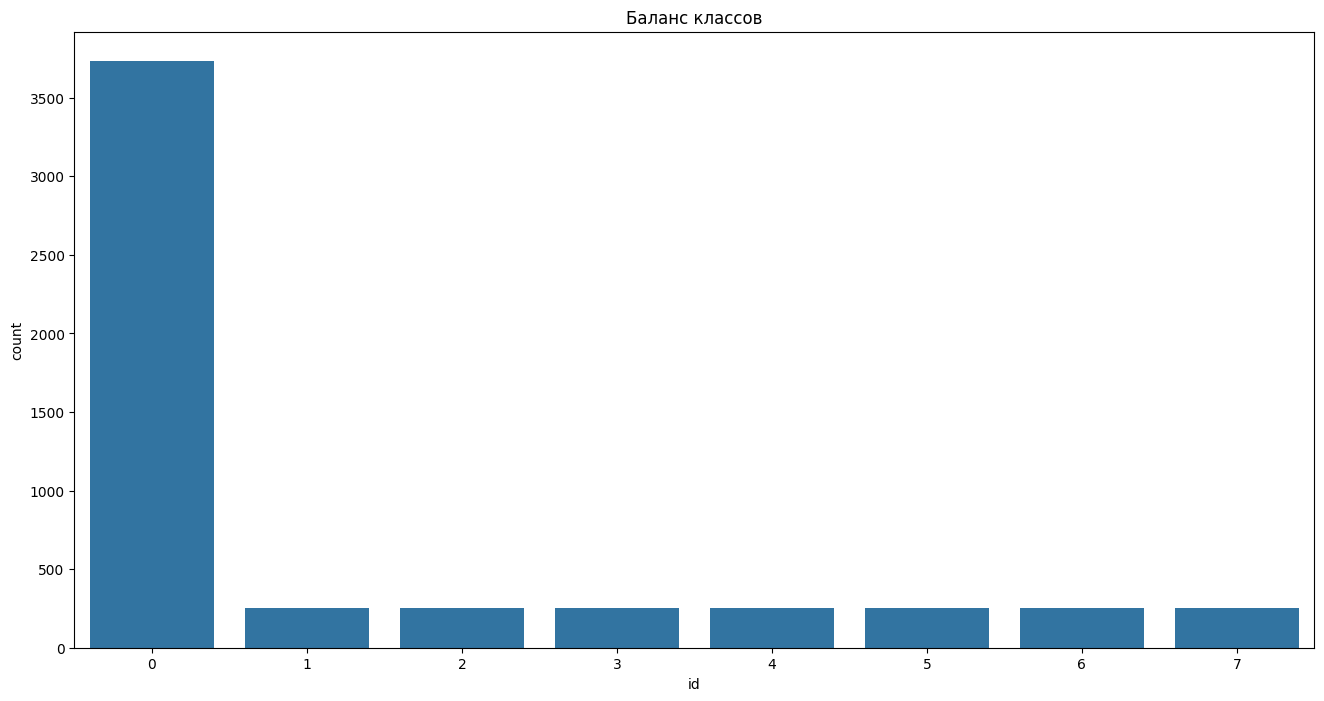

In [233]:
#new cell
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
sns.countplot(gestures, x='id', ax=ax)
ax.set_title('Баланс классов')


In [234]:
gestures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5484 entries, 0 to 5483
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   omg0    5484 non-null   float64
 1   omg1    5484 non-null   float64
 2   omg2    5484 non-null   float64
 3   omg3    5484 non-null   float64
 4   omg4    5484 non-null   float64
 5   omg5    5484 non-null   float64
 6   omg6    5484 non-null   float64
 7   omg7    5484 non-null   float64
 8   omg8    5484 non-null   float64
 9   omg9    5484 non-null   float64
 10  omg10   5484 non-null   float64
 11  omg11   5484 non-null   float64
 12  omg12   5484 non-null   float64
 13  omg13   5484 non-null   float64
 14  omg14   5484 non-null   float64
 15  omg15   5484 non-null   float64
 16  id      5484 non-null   int64  
dtypes: float64(16), int64(1)
memory usage: 728.5 KB


In [235]:
def get_trend(derivative):
    if derivative > 0:
        return 2
    elif derivative < 0:
        return 1
    else:
        return 0

def create_features(data, n_diff, sum_create=False, trend_create=False, mean_create=False):
    col_names = [f'omg{i}' for i in range(16)]  # Исправлено: omg0-omg15
    
    # Генерируем признаки производных и трендов для каждого столбца
    for col in col_names:
        diff_col = f'{col}_diff_{n_diff}'
        data[diff_col] = data[col].diff(n_diff).fillna(0)
        if trend_create:
            trend_col = f'{col}_trend_{n_diff}'
            data[trend_col] = data[diff_col].apply(get_trend)
    
    # Добавляем среднее значение (исправлено: вынесено из цикла)
    if mean_create:
        original_columns = [col for col in data.columns if col.startswith('omg')]
        shifted_data = data[original_columns].shift(n_diff).fillna(0)
        data[f'mean_{n_diff}'] = shifted_data.mean(axis=1)
    
    # Добавляем сумму производных
    if sum_create:
        diff_columns = [f'{col}_diff_{n_diff}' for col in col_names]
        data[f'sum_diff_{n_diff}'] = data[diff_columns].sum(axis=1)
    
    return data

def get_features(data, n_diff, count, sum_create=False, trend_create=False, mean_create=False):
    for i in range(1, count + 1):
        data = create_features(
            data, 
            n_diff * i, 
            sum_create=sum_create, 
            trend_create=trend_create, 
            mean_create=mean_create
        )
    return data

# Применяем исправленную функцию
gestures = get_features(gestures, 5, 3, sum_create=True, trend_create=True, mean_create=True)
print(f'Data shape: {gestures.shape}')
print(f'Итоговые столбцы:\n {gestures.columns.tolist()}')
gestures.head()

Data shape: (5484, 119)
Итоговые столбцы:
 ['omg0', 'omg1', 'omg2', 'omg3', 'omg4', 'omg5', 'omg6', 'omg7', 'omg8', 'omg9', 'omg10', 'omg11', 'omg12', 'omg13', 'omg14', 'omg15', 'id', 'omg0_diff_5', 'omg0_trend_5', 'omg1_diff_5', 'omg1_trend_5', 'omg2_diff_5', 'omg2_trend_5', 'omg3_diff_5', 'omg3_trend_5', 'omg4_diff_5', 'omg4_trend_5', 'omg5_diff_5', 'omg5_trend_5', 'omg6_diff_5', 'omg6_trend_5', 'omg7_diff_5', 'omg7_trend_5', 'omg8_diff_5', 'omg8_trend_5', 'omg9_diff_5', 'omg9_trend_5', 'omg10_diff_5', 'omg10_trend_5', 'omg11_diff_5', 'omg11_trend_5', 'omg12_diff_5', 'omg12_trend_5', 'omg13_diff_5', 'omg13_trend_5', 'omg14_diff_5', 'omg14_trend_5', 'omg15_diff_5', 'omg15_trend_5', 'mean_5', 'sum_diff_5', 'omg0_diff_10', 'omg0_trend_10', 'omg1_diff_10', 'omg1_trend_10', 'omg2_diff_10', 'omg2_trend_10', 'omg3_diff_10', 'omg3_trend_10', 'omg4_diff_10', 'omg4_trend_10', 'omg5_diff_10', 'omg5_trend_10', 'omg6_diff_10', 'omg6_trend_10', 'omg7_diff_10', 'omg7_trend_10', 'omg8_diff_10', 'omg

,omg0,omg1,omg2,omg3,omg4,omg5,omg6,omg7,omg8,omg9,...,omg12_diff_15,omg12_trend_15,omg13_diff_15,omg13_trend_15,omg14_diff_15,omg14_trend_15,omg15_diff_15,omg15_trend_15,mean_15,sum_diff_15
0,7365293.0,7675009.0,6742353.0,6808370.0,7095452.0,7348981.0,4504357.0,5455176.0,6249429.0,5232633.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0
1,7364723.0,7675728.0,6744021.0,6810516.0,7091509.0,7344326.0,4503962.0,5450863.0,6245452.0,5229499.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0
2,7366773.0,7677622.0,6743726.0,6811006.0,7089276.0,7346298.0,4501621.0,5451786.0,6242983.0,5229791.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0
3,7363720.0,7676388.0,6743597.0,6808710.0,7091128.0,7344922.0,4500847.0,5445076.0,6238155.0,5226395.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0
4,7367495.0,7678619.0,6744013.0,6809814.0,7087942.0,7346547.0,4500076.0,5445488.0,6239732.0,5224279.0,...,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0


In [236]:
#new cell
#зафиксируем переменные - кол-во временных шагов в одном лаге 
# (чтобы во временнной шаг всегда умещался жест и нейтральный статус) и кол-во классов,
# рассчитаем количество образцов в данных
time_steps = 40
num_classes = 8

In [237]:
#new cell
#записываем в переменную остаток от деления длины датасета на кол-во временных шагов
remainder = len(gestures)%time_steps
#отрезаем от данных первые строки (time steps) по количеству остатка, чтобы длина данных была кратна временному лагу
#отрезаем от начала данных, потому что, как правило, сначала идет задержка или нейтральное состояние датчиков
gestures = gestures[remainder:]
print(gestures.shape)

(5480, 119)


In [238]:
#new cell
num_samples = gestures.shape[0] // time_steps
print(num_samples)

137


In [239]:
#new cell
#разобьем данные на тренировочную и тестовые выборки, кратные временному лагу, в пропорции 0.8/0.2
X = gestures.drop('id', axis=1)
y = gestures['id']

test_start_index = (round(num_samples* 0.8)*time_steps)

In [240]:
#new cell
X_train = X.iloc[:test_start_index]
X_test = X.iloc[test_start_index:].reset_index(drop=True)
y_train = y.iloc[:test_start_index]
y_test = y.iloc[test_start_index:]

assert gestures.shape[0] == X_train.shape[0] + X_test.shape[0]

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (4400, 118)
Test shape: (1080, 118)


In [241]:
#new cell
# Создание объекта StandardScaler
scaler = preprocessing.StandardScaler()

# Масштабируем обучающие данные
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

# Масштабируем тестовые данные
scaler.fit(X_test)
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [242]:
#new cell - эта ячейка выполняется только при условии,
# что предварительно мы сформировали дополнительные признаки
selector = SelectKBest(f_classif, k=50)
selector.fit(X_train_scaled, y_train)

selected_features = selector.get_feature_names_out()
X_train = X_train_scaled[selected_features]
X_test = X_test_scaled[selected_features]

print(f'Отобранные признаки: {selector.get_feature_names_out()}')
print(f'Train Data shape: {X_train.shape}')
print(f'Test Data shape: {X_test.shape}')

Отобранные признаки: ['omg0' 'omg1' 'omg2' 'omg3' 'omg4' 'omg5' 'omg6' 'omg7' 'omg8' 'omg9'
 'omg10' 'omg11' 'omg12' 'omg13' 'omg14' 'omg15' 'omg2_trend_5'
 'omg3_trend_5' 'omg4_trend_5' 'omg5_trend_5' 'omg6_trend_5'
 'omg7_trend_5' 'omg8_trend_5' 'omg9_trend_5' 'mean_5' 'omg2_diff_10'
 'omg2_trend_10' 'omg3_trend_10' 'omg4_trend_10' 'omg5_trend_10'
 'omg6_trend_10' 'omg7_trend_10' 'omg8_trend_10' 'omg9_trend_10' 'mean_10'
 'omg2_diff_15' 'omg2_trend_15' 'omg3_trend_15' 'omg4_diff_15'
 'omg4_trend_15' 'omg5_diff_15' 'omg5_trend_15' 'omg6_trend_15'
 'omg7_trend_15' 'omg8_diff_15' 'omg8_trend_15' 'omg9_diff_15'
 'omg9_trend_15' 'omg10_trend_15' 'mean_15']
Train Data shape: (4400, 50)
Test Data shape: (1080, 50)


In [243]:
#new cell
#формируем данные для рекуррентной сети со слоем GRU
num_factors = len(X_train.columns)
X_train = X_train.values
X_test = X_test.values
X_train_gru = X_train.reshape(X_train.shape[0]//time_steps,time_steps,num_factors)
X_test_gru = X_test.reshape(X_test.shape[0]//time_steps,time_steps,num_factors)
print(X_train_gru.shape)
print(X_test_gru.shape)


(110, 40, 50)
(27, 40, 50)


In [244]:
#new cell
# Преобразуем целевую переменную в one-hot encoding
num_classes = 8 # Количество классов жестов
y_train_cat= to_categorical(y_train, num_classes=num_classes)
y_test_cat=to_categorical(y_test,num_classes=num_classes)
y_test_cat

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [245]:
print(y_train_cat.shape)
print(y_test_cat.shape)

(4400, 8)
(1080, 8)


In [246]:
#new cell
#целевую переменную также делим на лаги 
y_train_gru = y_train_cat.reshape(y_train_cat.shape[0]//time_steps,time_steps,num_classes)
y_test_gru = y_test_cat.reshape(y_test_cat.shape[0]//time_steps,time_steps,num_classes)

print(X_train_gru.shape)
print(X_test_gru.shape)
print(y_train_gru.shape)
print(y_test_gru.shape)

(110, 40, 50)
(27, 40, 50)
(110, 40, 8)
(27, 40, 8)


## Modeling

In [247]:
#new cell
# Создаем модель
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(GRU(100, input_shape=(time_steps, num_factors), return_sequences=True))
model.add(Dense(100, activation='relu'))
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))
model.summary()

optimizer = Adam(learning_rate=0.01)

model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_5 (GRU)                     │ (None, 40, 100)        │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 40, 100)        │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 40, 8)          │           808 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,508 (220.73 KB)

 Trainable params: 56,508 (220.73 KB)

 Non-trainable params: 0 (0.00 B)

In [257]:
#new cell
model.fit(X_train_gru, y_train_gru, epochs=24, batch_size=40, validation_split=0.2)

Epoch 1/24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9973 - loss: 0.0095 - val_accuracy: 0.9330 - val_loss: 0.2256
Epoch 2/24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9984 - loss: 0.0066 - val_accuracy: 0.9364 - val_loss: 0.2193
Epoch 3/24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9984 - loss: 0.0076 - val_accuracy: 0.9307 - val_loss: 0.2432
Epoch 4/24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9977 - loss: 0.0098 - val_accuracy: 0.9170 - val_loss: 0.3525
Epoch 5/24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9940 - loss: 0.0240 - val_accuracy: 0.9318 - val_loss: 0.2318
Epoch 6/24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9666 - loss: 0.3182 - val_accuracy: 0.8920 - val_loss: 0.3706
Epoch 7/24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9743 - loss: 0.0703 - val_accuracy: 0.9045 - val_loss: 0.4872
Epoch 8/24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9771 - loss: 0.0922 - val_accuracy: 0.8977 - val_loss: 0.5235


## Prediction

In [258]:
#new cell
predictions_train = model.predict(X_train_gru)
predictions_test = model.predict(X_test_gru)
print(predictions_train.shape)
print(predictions_test.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(110, 40, 8)
(27, 40, 8)


In [259]:
#new cell
y_train_proba=np.reshape(predictions_train,(predictions_train.shape[0]*time_steps,8))
y_test_proba = np.reshape(predictions_test,(predictions_test.shape[0]*time_steps,8))

print(y_train_proba.shape)
print(y_test_proba.shape)

(4400, 8)
(1080, 8)


In [260]:
#new cell
y_pred_train=np.argmax(y_train_proba,axis=1)
print(y_pred_train.shape)

y_pred_test = np.argmax(y_test_proba,axis=1)
print(y_pred_test.shape)

(4400,)
(1080,)


## Metrics

In [261]:
print(metrics.classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3000
           1       0.96      1.00      0.98       200
           2       0.99      0.95      0.97       200
           3       0.95      1.00      0.98       200
           4       0.96      0.89      0.92       200
           5       0.95      0.95      0.95       200
           6       0.99      0.96      0.98       200
           7       0.99      0.99      0.99       200

    accuracy                           0.99      4400
   macro avg       0.97      0.97      0.97      4400
weighted avg       0.99      0.99      0.99      4400



In [262]:
# Получаем отчёт как словарь
report = metrics.classification_report(y_train, y_pred_train, output_dict=True)

# Доступ к F1-score для "macro avg"
train_avg_f1 = report['macro avg']['f1-score']

print(f"Macro avg F1-score: {train_avg_f1}")

Macro avg F1-score: 0.9703846582416333


In [263]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       730
           1       0.92      0.66      0.77        50
           2       0.98      0.98      0.98        50
           3       0.76      1.00      0.86        50
           4       0.89      0.96      0.92        50
           5       0.98      0.82      0.89        50
           6       0.87      0.90      0.88        50
           7       0.96      0.94      0.95        50

    accuracy                           0.95      1080
   macro avg       0.91      0.90      0.90      1080
weighted avg       0.95      0.95      0.95      1080



In [264]:
report = metrics.classification_report(y_test, y_pred_test, output_dict=True)

# Доступ к F1-score для "macro avg"
test_avg_f1 = report['macro avg']['f1-score']

print(f"Macro avg F1-score: {test_avg_f1}")

Macro avg F1-score: 0.9039729741461727


In [22]:
last_train_idx = 3300
X_train = gestures[OMG_CH].values[:last_train_idx]
y_train = gestures['id'].values[:last_train_idx]

X_test = gestures[OMG_CH].values[last_train_idx:]
y_test = gestures['id'].values[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3300, 16) (3300,)
(2200, 16) (2200,)


# Baseline

# Modeling

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(
    X=X_train,
    y=y_train
)

LogisticRegression()

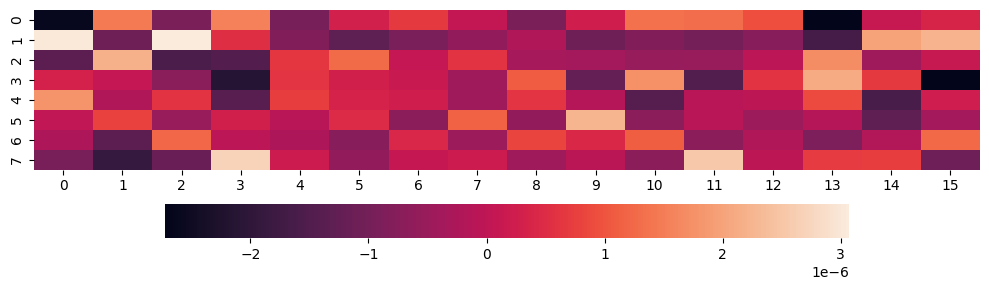

In [9]:
import seaborn as sns

plt.figure(figsize=(10, 3)) # 
sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
plt.tight_layout()

## Prediction

In [24]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

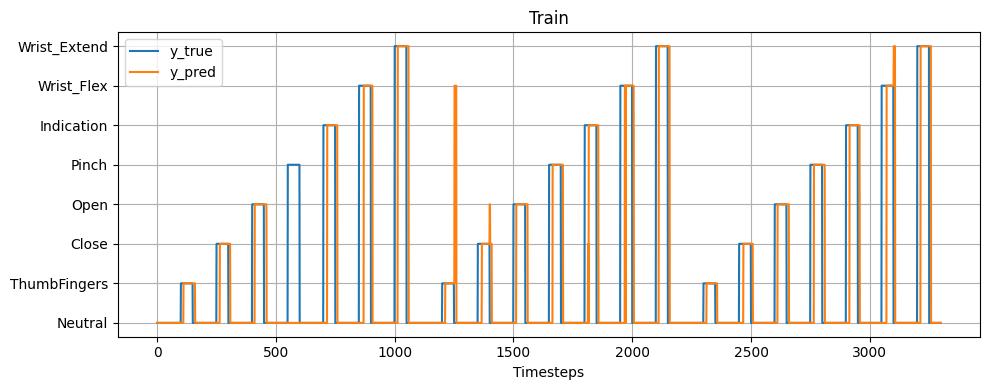

In [25]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

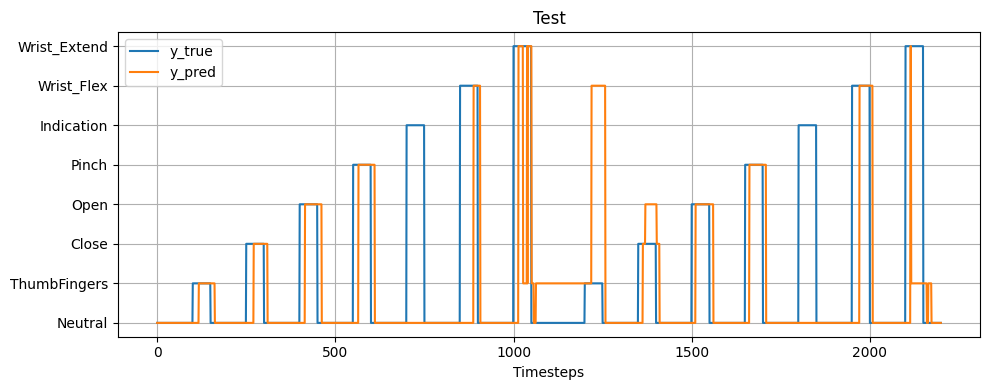

In [26]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [27]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.86      0.92      0.89      2250
ThumbFingers       0.85      0.75      0.80       150
       Close       0.80      0.67      0.73       150
        Open       0.78      0.77      0.77       150
       Pinch       0.78      0.47      0.58       150
  Indication       0.80      0.68      0.74       150
  Wrist_Flex       0.79      0.59      0.68       150
Wrist_Extend       0.78      0.74      0.76       150

    accuracy                           0.84      3300
   macro avg       0.81      0.70      0.74      3300
weighted avg       0.84      0.84      0.84      3300

              precision    recall  f1-score   support

     Neutral       0.81      0.83      0.82      1500
ThumbFingers       0.19      0.52      0.28       100
       Close       0.67      0.36      0.47       100
        Open       0.57      0.74      0.65       100
       Pinch       0.78      0.73      0.76       100
  Indication       0.00 

# Real-time inference

In [28]:
import time
import serial
from copy import deepcopy

## Inference Utils: Put your code here

In [15]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict_proba([x])[0]
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

## Inference

### Offline (dataset)

In [29]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(2200, 17)


In [30]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        td_ts, omg_sample, _ = np.array_split(sample, [2, 2 + N_OMG_CH])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample.astype(float))
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    # NO COMMANDS forming IN SIMULATION
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        # sanity check: Sizes of SAMPLE=65, OMG=16
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}', end='             \r')
    
    ts_diff = time.time() - ts_start
    # assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

TypeError: 'module' object is not callable

In [18]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (2200, 16)
sample_preprocessed.shape = (2200, 16)
y_predicted.shape = (2200, 8)
y_postprocessed.shape = (2200, 8)


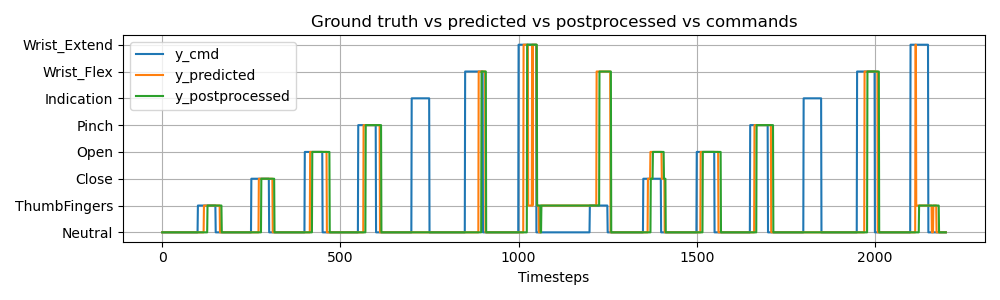

In [19]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'].argmax(axis=1), c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'].argmax(axis=1), c='C2', label='y_postprocessed')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [20]:
print(classification_report(y_test, y_dct['y_postprocessed'].argmax(axis=1), target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.76      0.79      0.77      1500
ThumbFingers       0.19      0.50      0.27       100
       Close       0.58      0.28      0.38       100
        Open       0.47      0.62      0.54       100
       Pinch       0.67      0.61      0.64       100
  Indication       0.00      0.00      0.00       100
  Wrist_Flex       0.32      0.25      0.28       100
Wrist_Extend       0.93      0.26      0.41       100

    accuracy                           0.65      2200
   macro avg       0.49      0.41      0.41      2200
weighted avg       0.66      0.65      0.64      2200



/home/user/miniconda3/envs/oemg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/miniconda3/envs/oemg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/miniconda3/envs/oemg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Online

#### Virtual hand

In [21]:
import VirtualPhantom
vp = VirtualPhantom.VirtualPhantomClient('localhost', 1755)

In [22]:
GESTURES

array(['Neutral', 'ThumbFingers', 'Close', 'Open', 'Pinch', 'Indication',
       'Wrist_Flex', 'Wrist_Extend'], dtype=object)

In [23]:
# Bindings for virtual hand
def commands(x):
    cmd = vp.neutral_state.copy()
    # for this mapping look at GESTURES
    if x == 0: # Pilot Neutral
        pass # Do nothing
    elif x == 1: # Pilot thumb_fingers
        # Virtual Hand thumb_fingers
        cmd.update({'thumb_flex': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 2: # Pilot close_state
        # Virtual Hand close_state
        cmd.update({'thumb_flex': 1, 'index_flex': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
    elif x == 3: # Pilot open_state
        cmd.update({'thumb_extend': 1, 'index_extend': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 4: # Pilot pinch_state
        cmd.update({'thumb_flex':1, 'index_flex': 1, 'middle_extend': 1, 'ring_extend': 1, 'pinky_extend': 1})
    elif x == 5: # Pilot indication_state
        cmd.update({ 'thumb_extend':1, 'index_extend': 1, 'middle_flex': 1, 'ring_flex': 1, 'pinky_flex': 1})
    elif x == 6: # Wrist_Flex
        cmd.update({'wrist_flex': 1})
    elif x == 7: # Wrist_Extend
        cmd.update({'wrist_extend': 1})
    else:
        pass # Do nothing
    
    return cmd

In [24]:
!ls /dev/ttyACM* /dev/ttyUSB*

/bin/bash: /home/user/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ls: cannot access '/dev/ttyUSB*': No such file or directory
 /dev/ttyACM0


In [25]:
ser_name = '/dev/ttyACM0'
try:
    ser.close()
except:
    pass
ser = serial.Serial(ser_name, baudrate=115200, timeout=60);

ser.write('PT1\r\n'.encode())
time.sleep(0.1)
ser.write('Pt1\r\n'.encode())
time.sleep(0.1)
ser.flush()
time.sleep(0.1)

def parseline():
    line = ser.readline().decode().replace('\n', '')
    data = np.array(list(filter(len, np.array(line.split(" "))))).astype(float)
    return data

In [25]:
TIMEOUT = 0.033
DEBUG = True

while(ser.in_waiting>50):
    ser.readline()
    time.sleep(0.005)
ser.readline()
    
t_start = time.time()
prev_idx = -1

y_previous = None
while True:    
    
    # [Data reading]
    t_rel = time.time() - t_start
    
    try: 
        data = parseline()
        data_line = ' '.join(data.astype(str))
        data_line += f' {-1} {"Inference"} {-1} {t_rel:.2f}'
    except Exception as e:
        raise(e)
        data_line = ' '.join(['-1']*n_cols)
        data_line += f' {-1} {"Error"} {-1} {t_rel:.2f}'

    td_ts, omg_sample, _ = np.array_split(data, [2, 2 + N_OMG_CH])        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed   = preprocessing(omg_sample.astype(float))
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted           = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed       = postprocessing(y_predicted, y_previous)
    y_postprocessed_label = y_postprocessed.argmax()
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed_label)
    # [/Commands composition]
    
    # [Commands sending]
    prot_idx = deepcopy(y_postprocessed_label)
    if (prot_idx != prev_idx):
        vp.send_cmd(**y_commands)
        prev_idx = deepcopy(prot_idx)
    # [/Commands sending]
    
    # [Data logging]
    # [/Data logging]

    y_previous = y_postprocessed.copy()
    time.sleep(0.001)
    t_rel = time.time() - t_start
    
    if DEBUG:
        # sanity check: Sizes of SAMPLE=65, OMG=16
        # print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}', end='             \r')
        # print(GESTURES[y_postprocessed_label], sample_preprocessed.tolist(), end='             \r')
        print(GESTURES[y_postprocessed_label], y_predicted, end='             \r')
    
    # assert(t_rel<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'

KeyboardInterrupt: 